In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import os
import pickle
# import scipy
# from scipy import signal
# import neurokit2 as nk
# import random
# %matplotlib inline 
# import pyhrv
import ipynb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import svm
# from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import AdaBoostClassifier

# functions for features extraction
from ipynb.fs.full.ECG_features import get_ecgfeatures
from ipynb.fs.full.EDA import get_edaindex, get_edafeatures
from ipynb.fs.full.BVP import get_bvpfeatures, bvp_prep

c:\Users\riche\AppData\Local\Programs\Python\Python39\lib\site-packages\antropy\fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit('float64(float64[:], int32)')


In [2]:
# Dataset reading
class read_data_of_one_subject:
            """Read data from WESAD dataset"""
            def __init__(self, path, subject):
                self.keys = ['label', 'subject', 'signal']
                self.signal_keys = ['wrist', 'chest']
                self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
                self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
                #os.chdir(path)
                #os.chdir(subject)
                with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
                    data = pickle.load(file, encoding='latin1')
                self.data = data

            def get_labels(self):
                return self.data[self.keys[0]]

            def get_wrist_data(self):
                """"""
                #label = self.data[self.keys[0]]
                #assert subject == self.data[self.keys[1]]
                signal = self.data[self.keys[2]]
                wrist_data = signal[self.signal_keys[0]]
                #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
                #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
                return wrist_data

            def get_chest_data(self):
                """"""
                signal = self.data[self.keys[2]]
                chest_data = signal[self.signal_keys[1]]
                return chest_data

In [10]:
# Set up empty dataframes for the features
ecgfeatures = pd.DataFrame(None, columns= ['ecg_HR_mean', 'ecg_HR_min', 'ecg_HR_max', 'ecg_HR_std', 'ecg_SDNN', 'ecg_SDANN', 'ecg_RMSSD', 
                                           'ecg_SDSD','ecg_pNN50', 'ecg_pNN20', "ecg_triangular_index", "ecg_tinn", "ecg_sd1", "ecg_sd2",
                                            "ecg_ratio_sd2_sd1", 'ecg_abs_power_VLF', 'ecg_abs_power_LF', 'ecg_abs_power_HF', 'ecg_tot_power',
                                            'ecg_LF/HF', 'ecg_peak_vlf', 'ecg_peak_lf', 'ecg_peak_hf', 'ecg_norm_power_LF', 'ecg_norm_power_HF',
                                            'resp_max', 'resp_min', 'resp_mean', 'resp_std'])
edafeatures = None
bvpfeatures = None

total_samples = 0
fs = 700 # sampling frequency
fs_bvp = 64
duration = 50
y = []
# data_set_path= "C:/Users/JackC/Documents/EPO4/WESAD/WESAD/" # Folder path
data_set_path= "C:/Users/riche/Downloads/WESAD/WESAD/" # Folder path
# data_set_path = "C:/Users/Adnane/Downloads/WESAD/WESAD/"

for i in range(15): # 15 subjects
    subject = 'S'+str(i+2) # Cycle through S2 to S17
    print(f"subject: {subject}")
    if subject != 'S12': # Skip S12, because it does not exist
        # Object instantiation
        obj_data = {}

        # Accessing class attributes and method through objects
        obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

        chest_data_dict = obj_data[subject].get_chest_data()
        wrist_data_dict = obj_data[subject].get_wrist_data()
        chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}
        wrist_dict_length = {key: len(value) for key, value in wrist_data_dict.items()}
        # Get labels
        labels = obj_data[subject].get_labels()

        for label in range(1,5): # for every state of stress
            
            baseline = np.asarray([idx for idx,val in enumerate(labels) if val == label])

            # Obtaining the chest data
            eda_base=chest_data_dict['EDA'][baseline,0] # Select the EDA data
            ecg_base=chest_data_dict['ECG'][baseline,0] # Select the ECG data
            resp_base=chest_data_dict['Resp'][baseline,0] # Select the respiration data

            # Obtaining the wrist data
            baseline_BVP = baseline * fs_bvp // fs
            bvp_base=wrist_data_dict['BVP'][baseline_BVP,0] # Select the BVP data

            # Multiple smaller samples per signal
            # samples = 10 # specify amount of samples

            total_samples += len(eda_base)//(duration*fs)

            for j in range(len(eda_base)//(duration*fs)): # loop over all segments

                # adding the labels to y
                if label==3 or label==4: # if amusement or medidation, classify as non-stress
                    y.append(1)
                else:
                    y.append(label)

                # Cutting the signal into a segment
                ecg = ecg_base[j*fs*duration: (j+1)*fs*duration]
                eda = eda_base[j*fs*duration: (j+1)*fs*duration]
                bvp = bvp_base[j*fs*duration: (j+1)*fs*duration]

                # splitting sample into 10 smaller even-sized parts
                #ecg = ecg_base[int(len(ecg_base)* (j/samples)) : int(len(ecg_base)* ((j+1)/samples))]
                #eda = eda_base[int(len(eda_base)* (j/samples)) : int(len(eda_base)* ((j+1)/samples))]

                # getting the eda and ecg features
                index = subject + str(label) + str(j)
                tonic, phasic, start, end = get_edaindex(eda, fs)
                edafeatures = get_edafeatures(index, edafeatures, phasic, tonic, fs)
                ecgfeatures = get_ecgfeatures(ecg, fs, ecgfeatures, index)
                
                bvpfeature = get_bvpfeatures(bvp, fs_bvp, index)
                bvpfeatures = pd.concat([bvpfeatures, bvpfeature], axis=0)
    print(f"total samples: {total_samples}")

subject: S2
total samples: 56
subject: S3
total samples: 112
subject: S4
total samples: 170
subject: S5
total samples: 227
subject: S6
total samples: 285
subject: S7
total samples: 342
subject: S8
total samples: 400
subject: S9
total samples: 457
subject: S10
total samples: 516
subject: S11
total samples: 574
subject: S12
total samples: 574
subject: S13
total samples: 632
subject: S14
total samples: 690
subject: S15
total samples: 748
subject: S16
total samples: 806


In [11]:
bvp_filt = bvp_prep(bvpfeatures) # remove nan and inf in BVP features

# saving the feature data in csv files
edafeatures.to_csv("EDA_features.csv")
ecgfeatures.to_csv("ECG_features.csv")
bvp_filt.to_csv("BVP_features.csv")

In [13]:
# #reading from csv file if necessary
# edafeatures = pd.read_csv("EDA_features.csv", index_col=0)
# ecgfeatures = pd.read_csv("ECG_features.csv", index_col=0)
# bvp_filt = pd.read_csv("BVP_features.csv", index_col=0)
#features = pd.read_csv("features_"+str(samples)+"_samp.csv", index_col=0)


In [30]:
feat = ecgfeatures
bvp_filt.head()

,index,PPG_Rate_Baseline,PPG_Rate_Max,PPG_Rate_Min,PPG_Rate_Mean,PPG_Rate_SD,PPG_Rate_Max_Time,PPG_Rate_Min_Time,PPG_Rate_Trend_Quadratic,PPG_Rate_Trend_Linear,...,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,HRV_DFA_alpha2,HRV_DFA_alpha2_ExpRange,HRV_DFA_alpha2_ExpMean,HRV_DFA_alpha2_DimRange,HRV_DFA_alpha2_DimMean,copy_index
0,0,48.818489,43.489204,0.000000,9.979552,9.622066,1.598849,0.001051,-8.408618,26.566979,...,1.521458,2.039230,3.729608,1.012702,0.466743,4.370556,1.966372,10.79581,-1.172623,0
1,0,43.367642,61.895516,-14.382135,4.133975,21.035197,1.715908,1.213657,47.263200,-66.700656,...,1.482361,1.989264,4.228529,1.114525,0.466743,4.370556,1.966372,10.79581,-1.172623,1
2,0,43.781671,94.149364,-11.172975,9.772093,25.191039,1.024562,0.469285,-3.064716,24.707961,...,1.311088,1.976917,4.232995,1.218255,0.466743,4.370556,1.966372,10.79581,-1.172623,2
3,0,44.594124,0.000000,-25.516222,-19.780307,8.345637,0.001051,0.839470,19.192502,-47.284513,...,1.411827,1.978904,2.803219,0.984375,0.466743,4.370556,1.966372,10.79581,-1.172623,3
4,0,48.303023,96.275290,-10.328340,1.885733,21.692507,1.724912,0.870485,43.679597,-64.399576,...,1.414009,1.989614,4.471740,1.177954,0.301560,5.419723,1.818131,4.80945,-1.290335,4


In [29]:
feat['copy_index'] = feat.index
feat.merge(bvp_filt, how='left')
# feat.reset_index().merge(bvp_filt, how="left").set_index('index')

feat.head()
# pd.merge_asof(ecgfeatures, features1)
# feat.head()
# features1 = pd.merge(ecgfeatures, edafeatures, left_index=True, right_index=True)
# features1.reset_index(drop=True, inplace=True)
# ecgfeatures.head()
# features = pd.merge(ecgfeatures, bvp_filt, left_index=True, right_index=True)
# features.head()
# features.to_csv("features_"+str(samples)+"_samp.csv") # csv for smaller samples

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [50]:
total_features = features
y_feat = y

Splitting the data in train and test data

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=5)

# Scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

600


# Performing PCA

In [51]:
# normalize data
scaler = StandardScaler().fit(features)
X_train = scaler.transform(features)

n = 25
# perform PCA
pca = PCA(n_components=n)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
x_train = X_train_pca
# x_train = X_train_pca[:,0:3] # Three best features

# plot two best features
# plt.figure(figsize=(8,6))
# plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y)

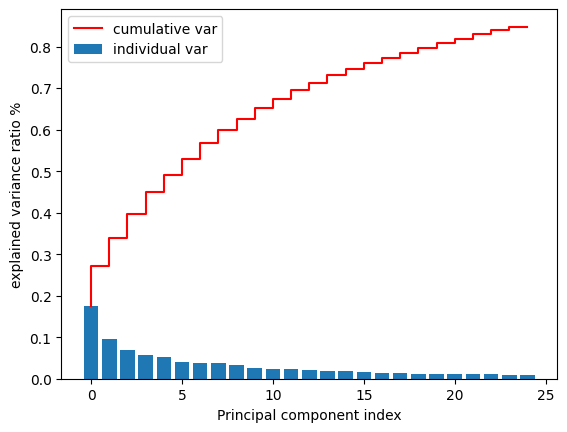

In [53]:
# plot feature variance
plt.bar(range(0,n), pca.explained_variance_ratio_, label="individual var");
plt.step(range(0,n), np.cumsum(pca.explained_variance_ratio_),'r', label="cumulative var");
plt.xlabel('Principal component index'); plt.ylabel('explained variance ratio %');
plt.legend()

# Logistic regression

In [55]:

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
Y_test_pred = logistic_model.predict(X_test)
log_score = logistic_model.score(X_test,y_test)

# SVM

In [56]:

svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
Y_test_pred = svm_model.predict(X_test)
svm_score = svm_model.score(X_test,y_test)

# Neural Networks

In [58]:
val_accuracies = []
for i in range(5): # run 5 times with 5 random states to determine model accuracy
    # Splitting the data in train and test data
    X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.2, random_state= i + 1)

    # Scaling the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    ## Convert labels to categorical
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    # Define the feedforward neural network
    neural_model = Sequential()
    neural_model.add(Dense(64, activation='relu', input_shape=(25,)))
    neural_model.add(Dense(64, activation='relu'))
    neural_model.add(Dense(64, activation='relu'))
    neural_model.add(Dense(64, activation = 'relu'))
    neural_model.add(Dropout(0.5))
    neural_model.add(Dense(3, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    neural_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model
    # history = model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=45, batch_size=100, verbose=2)
    history = neural_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=45, batch_size=100, verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    val_accuracies.append(val_accuracy) # accuracy score

print(val_accuracies)
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies) # average of accurracy scores
print("Average Validation Accuracy:", avg_val_accuracy)

[0.925000011920929, 0.9166666865348816, 0.9083333611488342, 0.8999999761581421, 0.8916666507720947]
Average Validation Accuracy: 0.9083333373069763


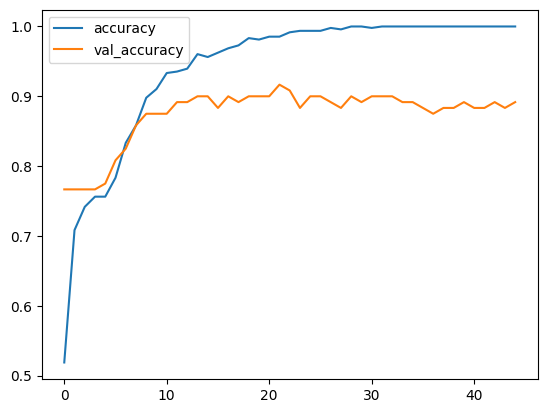

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

# AdaBoost

In [60]:
# Import the AdaBoost classifier
Ada_scores = [[]]*200
for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.3, random_state= i+1)
    # Create adaboost classifer object
    abc= AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=5)

    # Train Adaboost Classifer
    adaboost_model = abc.fit(X_train, y_train)


#Predict the response for test dataset
# y_pred = model1.predict(X_test)
    score30= adaboost_model.score(X_test, y_test)
    Ada_scores[i] = score30
print(Ada_scores)
print(np.mean(Ada_scores))
#predictions = adaboost_model.predict(X_test)
#print(predictions != y_test)
#print(score30)

[0.8777777777777778, 0.9166666666666666, 0.9055555555555556, 0.9111111111111111, 0.9055555555555556, 0.8888888888888888, 0.8833333333333333, 0.9111111111111111, 0.8888888888888888, 0.9, 0.9, 0.9111111111111111, 0.8944444444444445, 0.8888888888888888, 0.8944444444444445, 0.9166666666666666, 0.8611111111111112, 0.9111111111111111, 0.8777777777777778, 0.85, 0.9055555555555556, 0.8888888888888888, 0.8888888888888888, 0.8944444444444445, 0.9277777777777778, 0.9, 0.9222222222222223, 0.9111111111111111, 0.9111111111111111, 0.9111111111111111, 0.9, 0.8555555555555555, 0.9333333333333333, 0.9111111111111111, 0.8722222222222222, 0.8833333333333333, 0.9222222222222223, 0.8777777777777778, 0.9277777777777778, 0.8666666666666667, 0.8888888888888888, 0.9, 0.9, 0.9, 0.8666666666666667, 0.8888888888888888, 0.8944444444444445, 0.8944444444444445, 0.9055555555555556, 0.8888888888888888, 0.9333333333333333, 0.8666666666666667, 0.9111111111111111, 0.8833333333333333, 0.9166666666666666, 0.9277777777777778

0.9083333333333333
120


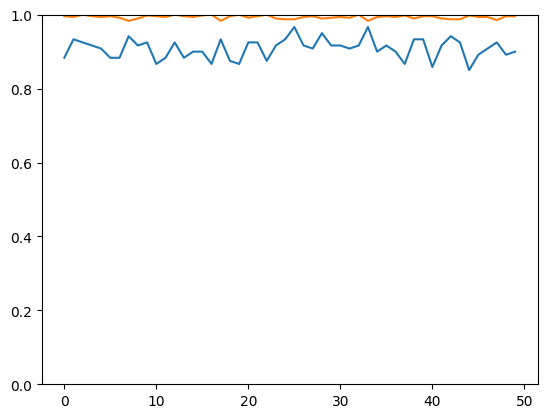

In [61]:
from sklearn.tree import DecisionTreeClassifier
scores_ada = []
trainscores_ada = []
for i in range (50):
      dtree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1)
      adbclassifier = AdaBoostClassifier(base_estimator=dtree,
                                    n_estimators=100,
                                    learning_rate=1,
                                    algorithm = 'SAMME',
                                    random_state=1)
      X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.2, random_state= i+1)
      adbclassifier.fit(X_train, y_train)
      scores_ada.append(adbclassifier.score(X_test,y_test))
      trainscores_ada.append(adbclassifier.score(X_train,y_train))
print(np.mean(scores_ada))
print(len(X_test))
plt.ylim(0,1)
plt.plot(scores_ada)
plt.plot(trainscores_ada)

# XGBoost

In [116]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
label = LabelEncoder()
y2 = label.fit_transform(y)
y2 = list(y2)
xg_scores = []
xg_trainscores = []
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(x_train, y2, test_size=0.2, random_state= i)
    xgb_clf = XGBClassifier(n_estimators = 500,
                            learning_rate = 1,
                            eval_metric = "logloss",
                            early_stopping_rounds = 5,
                            n_jobs = -1,
                            )
    xgb_clf.fit(X_train, y_train,                    
                eval_set = [(X_test,y_test)],
                verbose = False)
    pred_test = xgb_clf.predict(X_test)
    test_score = accuracy_score(pred_test, y_test)
    xg_scores.append(test_score)
    pred_train = xgb_clf.predict(X_train)
    train_score = accuracy_score(pred_train, y_train)
    xg_trainscores.append(train_score)
print(np.mean(xg_scores))
print(np.mean(xg_trainscores))


0.8877833333333334
0.9984166666666667


0.9666666666666667


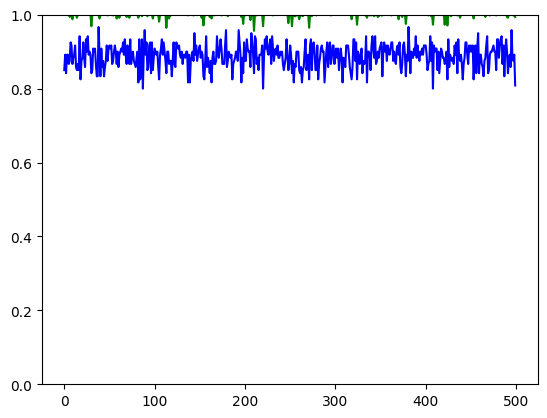

In [113]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
plt.ylim(0,1)
plt.plot(xg_scores, c = 'blue')
plt.plot(xg_trainscores, c = 'green')
print(np.max(xg_scores))


In [114]:
from sklearn.metrics import accuracy_score
pred_test = xgb_clf.predict(X_test)
test_score = accuracy_score(pred_test, y_test)
print("Test score:", np.round(test_score,2))
print(pred_test)

Test score: 0.81
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 1]


In [115]:
print(np.max(Ada_scores))

0.95


# Nieuwe XGBOOST test

In [137]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
ac_xgb1 = []
ac_xgb2 = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(x_train, y2, test_size=0.2, random_state= i+1)
    dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Define hyperparameters
    params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

    n = 100
    xgb_model1 = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    )
    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
    xgb_model2 = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=250,
    )
    preds = xgb_model1.predict(dtest_reg)
    preds1 = xgb_model2.predict(dtest_reg)
    preds = np.round(preds)
    preds1 = np.round(preds1)
    error= np.sum(preds!=y_test)
# print(preds!=y_test)
    accuracy = 1 - error/preds.size
    ac_xgb1.append(accuracy)
    error1 = np.sum(preds1 != y_test)
    accuracy2 = 1- error1/preds1.size
    ac_xgb2.append(accuracy2)
print(np.mean(ac_xgb1))
print(np.mean(ac_xgb2))

[0]	train-rmse:0.37545	validation-rmse:0.44465
[99]	train-rmse:0.00070	validation-rmse:0.33042
[0]	train-rmse:0.37579	validation-rmse:0.41780
[99]	train-rmse:0.00065	validation-rmse:0.27674
[0]	train-rmse:0.37633	validation-rmse:0.43677
[99]	train-rmse:0.00071	validation-rmse:0.35459
[0]	train-rmse:0.37684	validation-rmse:0.41910
[99]	train-rmse:0.00074	validation-rmse:0.27481
[0]	train-rmse:0.37896	validation-rmse:0.42616
[99]	train-rmse:0.00062	validation-rmse:0.32863
[0]	train-rmse:0.38412	validation-rmse:0.42047
[99]	train-rmse:0.00071	validation-rmse:0.30028
[0]	train-rmse:0.37813	validation-rmse:0.42446
[99]	train-rmse:0.00063	validation-rmse:0.34444
[0]	train-rmse:0.37937	validation-rmse:0.42292
[99]	train-rmse:0.00061	validation-rmse:0.27656
[0]	train-rmse:0.38138	validation-rmse:0.39927
[99]	train-rmse:0.00059	validation-rmse:0.27846
[0]	train-rmse:0.37807	validation-rmse:0.43316
[99]	train-rmse:0.00069	validation-rmse:0.33190
0.8699999999999999
0.8699999999999999


# Random forest method

In [70]:
#from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# define the model
randomf_model = RandomForestClassifier()

# fit/train the model on all features
randomf_model.fit(X_train, y_train)
Y_test_pred = randomf_model.predict(X_test)

# score
rf_score=randomf_model.score(X_test, y_test)

# get feature importance
importance = randomf_model.feature_importances_

#creat a dictionary with key=indices, and values=importance
important_features_dict = {}
for idx, val in enumerate(importance):
    important_features_dict[idx] = val
# sorting 
important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)
# print indices of top 5 features
print(important_features_list[:5])
#plt.plot(importance)

[1, 13, 4, 0, 2]


# Scores

In [71]:
y_test_cat = to_categorical(y_test)
y_test1 = y_test_cat.astype('int64')
testYarg = np.argmax(y_test1, axis = 1)

In [72]:
# function which gives predicted and correct values with missclassifications and scores for neural network
def model_predict_neural(X_test, y_test1, model):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis = 1)
    y_test1 = y_test1.astype('int64')
    testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != testYarg)
    miss_class = miss_class[0]
    print("Neural network")
    print("Predicted:",predictions)
    print("Correct:  ",testYarg)
    print("Index missclassified:", miss_class)
    print("Score:", val_accuracy, "\n")
    return predictions, miss_class, testYarg

In [73]:
# function which gives predicted and correct values with missclassifications and scores for rest models
def model_predict(X_test, y_test1, model):
    predictions = model.predict(X_test)
    #y_test1 = y_test1.astype('int64')
    #testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != y_test1)
    miss_class = miss_class[0]
    score=model.score(X_test, y_test1)
    print(model)
    print("Predicted:",predictions)
    print("Correct:  ",testYarg)
    print("Index missclassified:", miss_class)
    print("Score:", score, "\n")
    return predictions, miss_class, testYarg

In [74]:
model_predict_neural(X_test, y_test_cat, neural_model)
model_predict(X_test, y_test, logistic_model)
model_predict(X_test, y_test, svm_model)
predictions = model_predict(X_test, y_test, randomf_model)

4/4 [==============================] - 0s 2ms/step
Neural network
Predicted: [1 2 1 2 1 1 1 1 1 1 1 2 1 1 2 1 1 2 2 1 1 1 1 2 2 1 1 2 2 1 1 1 2 2 1 2 1
 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 2 1 1 2 1 2 2 1 1 1 1 1 2 1 1
 1 1 1 1 2 1 1 1 2 2 1 1 1 1 1 1 2 1 2 1 2 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 2
 2 2 1 2 2 2 1 1 2]
Correct:   [0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0
 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 1 0 1 1 0 0 0 1]
Index missclassified: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 10

# Cross-validation score of different models

In [75]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# k-fold Cross-Validation
def cross_validation(X, y, model):
    cv = KFold(n_splits= 5, random_state=1, shuffle=True)
    scores = cross_val_score(model, X,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return scores

In [94]:
# perform on all models
print("Logistic regression")
cv_logistic = cross_validation(features, y, logistic_model)
print(cv_logistic,"\n\nSVM")
cv_svm = cross_validation(features, y, svm_model)
print(cv_svm, "\n\nRandomforest")
cv_randomf = cross_validation(features, y, randomf_model)
print(cv_randomf, "\n\nNeural Network")
cv_adaboost = cross_validation(features, y, adbclassifier)
print(cv_adaboost, "\n\nAda Boost")
# cv_xgb_clf = cross_validation(features, y2, xgb_clf)
# print(cv_xgb_clf, "\n\nXG_Boost")
print("Accuracy:", avg_val_accuracy)
print(val_accuracies)
print ('ACC std:', '{0:0.3f}'.format(np.std(val_accuracies)), "\n")

Logistic regression
Accuracy: 0.898 (0.032)
[0.84166667 0.93333333 0.925      0.9        0.89166667] 

SVM
Accuracy: 0.750 (0.050)
[0.75       0.80833333 0.76666667 0.65833333 0.76666667] 

Randomforest
Accuracy: 0.925 (0.020)
[0.91666667 0.925      0.95       0.94166667 0.89166667] 

Neural Network
Accuracy: 0.932 (0.014)
[0.90833333 0.93333333 0.925      0.94166667 0.95      ] 

Ada Boost
Accuracy: 0.9083333373069763
[0.925000011920929, 0.9166666865348816, 0.9083333611488342, 0.8999999761581421, 0.8916666507720947]
ACC std: 0.012 



Subject Based

In [29]:
features = total_features
feat_list = []

# take the features from each subject
for a in range(15):
    df = features[a*samples*4:(a+1)*samples*4]
    feat_list.append(df)

In [30]:
# define output for each subject
y_sb1 = []
for i in range(1):
    y_sb1.extend(samples * [1])
    y_sb1.extend(samples * [2])
    y_sb1.extend(samples * [1])
    y_sb1.extend(samples * [1])
len(feat_list)

# output for whole sample
y_sb2 = []
for i in range(1):
    y_sb2.extend([1,2,1,1])
len(feat_list)

15

In [31]:
# initialize values for model score lists
nnmean_sb = []
nnstd_sb = []
acc_sb = {}
acc_sb['LogisticRegression()'] = []
acc_sb['SVC()'] = []
acc_sb['RandomForestClassifier()'] = []
std_sb = {}
std_sb['LogisticRegression()'] = []
std_sb['SVC()'] = []
std_sb['RandomForestClassifier()'] = []

In [32]:
for features in feat_list: # cycle through each subject
    scaler_sb = StandardScaler().fit(features)
    X_train_sb = scaler_sb.transform(features)

    # perform PCA
    pca = PCA(n_components=4)
    pca.fit(X_train_sb)
    X_train_pca_sb = pca.transform(X_train_sb)
    x_train_sb = X_train_pca_sb[:,0:3] # Three best features

    # plt.figure(figsize=(8,6))
    # plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y)
    # # perform pca on features
    # plt.bar(range(0,15), pca.explained_variance_ratio_, label="individual var");
    # plt.step(range(0,15), np.cumsum(pca.explained_variance_ratio_),'r', label="cumulative var");
    # plt.xlabel('Principal component index'); plt.ylabel('explained variance ratio %');
    # plt.legend()

    # Splitting the data in train and test data
    X_train_sb, X_test_sb, y_train_sb, y_test_sb = train_test_split(x_train_sb, y_sb1, test_size=0.2, random_state=5)

    # Scaling the data
    scaler_sb = StandardScaler().fit(X_train_sb)
    X_train_sb = scaler_sb.transform(X_train_sb)
    X_test_sb = scaler_sb.transform(X_test_sb)

    # logistic regression
    logistic_model_sb = LogisticRegression()
    logistic_model_sb.fit(X_train_sb, y_train_sb)
    Y_test_pred_sb = logistic_model_sb.predict(X_test_sb)
    log_score_sb = logistic_model_sb.score(X_test_sb,y_test_sb)

    # SVM
    from sklearn import datasets, svm
    svm_model_sb = svm.SVC()
    svm_model_sb.fit(X_train_sb, y_train_sb)
    Y_test_pred = svm_model_sb.predict(X_test_sb)
    svm_score = svm_model_sb.score(X_test_sb,y_test_sb)

    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam

    # neural network
    val_accuracies_sb = []
    for i in range(5): # run 5 times with 5 random states to determine model accuracy
        # Splitting the data in train and test data
        X_trainn_sb, X_testn_sb, y_trainn_sb, y_testn_sb = train_test_split(x_train_sb, y_sb1, test_size=0.2, random_state= i + 1)

        # Scaling the data
        scaler_sb = StandardScaler().fit(X_trainn_sb)
        X_trainn_sb = scaler_sb.transform(X_trainn_sb)
        X_testn_sb = scaler_sb.transform(X_testn_sb)
        ## Convert labels to categorical
        y_train_cat_sb = to_categorical(y_trainn_sb,3)
        y_test_cat_sb = to_categorical(y_testn_sb,3)

        # Define the feedforward neural network
        neural_model_sb = Sequential()
        neural_model_sb.add(Dense(64, activation='relu', input_shape=(3,)))
        neural_model_sb.add(Dense(64, activation='relu'))
        neural_model_sb.add(Dense(64, activation='relu'))
        neural_model_sb.add(Dense(64, activation = 'relu'))
        neural_model_sb.add(Dropout(0.5))
        neural_model_sb.add(Dense(3, activation='softmax'))

        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        neural_model_sb.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])

        # Train the model

        # history = model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=45, batch_size=100, verbose=2)
        history = neural_model_sb.fit(X_trainn_sb, y_train_cat_sb, validation_data=(X_testn_sb, y_test_cat_sb), epochs=45, batch_size=100, verbose=0)
        val_accuracy_sb = history.history['val_accuracy'][-1]
        val_accuracies_sb.append(val_accuracy_sb) # accuracy score

    # print(val_accuracies)
    avg_val_accuracy_sb = sum(val_accuracies_sb) / len(val_accuracies_sb) # average of accurracy scores
    # print("Average Validation Accuracy:", avg_val_accuracy)
    # plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    # plt.legend(['accuracy', 'val_accuracy'])
    #from sklearn.datasets import make_classification
    from sklearn.ensemble import RandomForestClassifier

    # Random forest
    # define the model
    randomf_model_sb = RandomForestClassifier()

    # fit/train the model on all features
    randomf_model_sb.fit(X_train_sb, y_train_sb)
    Y_test_pred_sb = randomf_model_sb.predict(X_test_sb)

    #score
    rf_score_sb=randomf_model_sb.score(X_test_sb, y_test_sb)
    
    # determine model score 
    y_test_cat_sb = to_categorical(y_test_sb)
    y_test1_sb = y_test_cat_sb.astype('int64')
    testYarg_sb = np.argmax(y_test1_sb, axis = 1)

    def model_predict_neural(X_test, y_test1, model):
        predictions = model.predict(X_test)
        predictions = np.argmax(predictions, axis = 1)
        y_test1 = y_test1.astype('int64')
        testYarg = np.argmax(y_test1, axis = 1)
        miss_class = np.where(predictions != testYarg_sb)
        miss_class = miss_class[0]
        # print("Neural network")
        # print("Predicted:",predictions)
        # print("Correct:  ",testYarg)
        # print("Index missclassified:", miss_class)
        # print("Score:", val_accuracy, "\n")
        return predictions, miss_class, testYarg
    def model_predict(X_test, y_test1, model):
        predictions = model.predict(X_test)
        #y_test1 = y_test1.astype('int64')
        #testYarg = np.argmax(y_test1, axis = 1)
        miss_class = np.where(predictions != y_test1)
        miss_class = miss_class[0]
        score=model.score(X_test, y_test1)
        # print(model)
        # print("Predicted:",predictions)
        # print("Correct:  ",testYarg)
        # print("Index missclassified:", miss_class)
        # print("Score:", score, "\n")
        return predictions, miss_class, testYarg
    # model_predict_neural(X_test, y_test_cat, neural_model)
    # model_predict(X_test, y_test, logistic_model)
    # model_predict(X_test, y_test, svm_model)
    # predictions = model_predict(X_test, y_test, randomf_model)
    from numpy import mean
    from numpy import std
    from sklearn.datasets import make_classification
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    from sklearn.linear_model import LogisticRegression

    def cross_validation(X, y, model, acc_d, std_d):
        cv = KFold(n_splits= 5, random_state=1, shuffle=True)
        scores = cross_val_score(model, X,y, scoring='accuracy', cv=cv, n_jobs=-1)
        # print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
        # print(str(model))
        acc_sb[str(model)].append(mean(scores))
        std_sb[str(model)].append(std(scores))
        return scores
    print("Logistic regression")
    cv_logistic = cross_validation(features, y_sb1, logistic_model_sb, acc_sb, std_sb)
    print(cv_logistic,"\n\nSVM")
    cv_svm = cross_validation(features, y_sb1, svm_model_sb, acc_sb, std_sb)
    print(cv_svm, "\n\nRandomforest")
    cv_randomf = cross_validation(features, y_sb1, randomf_model_sb, acc_sb, std_sb)
    print(cv_randomf, "\n\nNeural Network")
    # print("Accuracy:", avg_val_accuracy)
    # print(val_accuracies)
    # print ('ACC std:', '{0:0.3f}'.format(np.std(val_accuracies)), "\n")
    nnmean_sb.append(avg_val_accuracy_sb)
    nnstd_sb.append(np.std(val_accuracies_sb))

Logistic regression
[0.875 0.875 0.75  0.75  0.875] 

SVM
[1.    0.75  0.75  0.625 0.625] 

Randomforest
[1.    1.    0.75  0.75  0.875] 

Neural Network
Logistic regression
[1.    1.    1.    1.    0.875] 

SVM
[1.    0.625 0.75  0.625 0.625] 

Randomforest
[1.    1.    0.875 1.    0.75 ] 

Neural Network
Logistic regression
[0.875 0.875 1.    0.75  1.   ] 

SVM
[1.    0.75  0.75  0.625 0.625] 

Randomforest
[1. 1. 1. 1. 1.] 

Neural Network
Logistic regression
[1.    0.875 1.    0.875 0.875] 

SVM
[1.    0.75  0.75  0.625 0.625] 

Randomforest
[1.    1.    1.    1.    0.875] 

Neural Network
Logistic regression
[1.    0.625 0.875 0.875 0.75 ] 

SVM
[1.    0.75  0.75  0.625 0.625] 

Randomforest
[1.    0.625 1.    1.    0.75 ] 

Neural Network
Logistic regression
[1. 1. 1. 1. 1.] 

SVM
[1.    0.75  0.75  0.625 0.5  ] 

Randomforest
[1. 1. 1. 1. 1.] 

Neural Network
Logistic regression
[1.    0.875 1.    0.875 1.   ] 

SVM
[1.    0.75  0.75  0.625 0.625] 

Randomforest
[1.    1.    1. 

In [33]:
print("Logistic regression")
print("{:.5f}".format(mean(acc_sb['LogisticRegression()'])))
print("{:.5f}".format(mean(std_sb['LogisticRegression()'])), "\n\nSVM")
print("{:.5f}".format(mean(acc_sb['SVC()'])))
print("{:.5f}".format(mean(std_sb['SVC()'])), "\n\nRandomforest")
print("{:.5f}".format(mean(acc_sb['RandomForestClassifier()'])))
print("{:.5f}".format(mean(std_sb['RandomForestClassifier()'])), "\n\nNeural Network")
print("{:.5f}".format(mean(nnmean_sb)))
print("{:.5f}".format(mean(nnstd_sb)))


Logistic regression
0.89833
0.08000 

SVM
0.74833
0.13176 

Randomforest
0.95500
0.05208 

Neural Network
0.94167
0.05483


# Hybrid approach

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, svm
from sklearn.ensemble import RandomForestClassifier

In [35]:
features = total_features
feat_list = []

# extract features from each subject
for a in range(15):
    df = features[a*samples*4:(a+1)*samples*4]
    feat_list.append(df)

In [36]:
# define output for each subject
y_hy1 = []
for i in range(1):
    y_hy1.extend(samples * [1])
    y_hy1.extend(samples * [2])
    y_hy1.extend(samples * [1])
    y_hy1.extend(samples * [1])
len(feat_list)

y_hy2 = []
for i in range(1):
    y_hy2.extend([1,2,1,1])
len(feat_list)

15

In [37]:
nnmean_hy = []
nnstd_hy = []
acc_hy = {}
acc_hy['LogisticRegression()'] = []
acc_hy['SVC()'] = []
acc_hy['RandomForestClassifier()'] = []
std_hy = {}
std_hy['LogisticRegression()'] = []
std_hy['SVC()'] = []
std_hy['RandomForestClassifier()'] = []

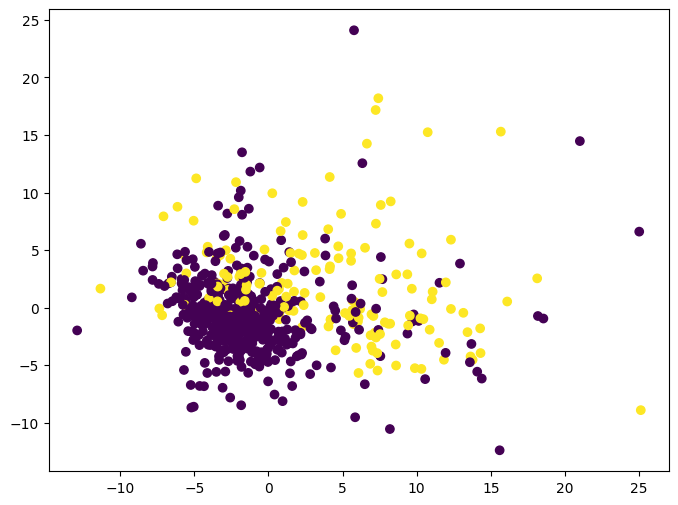

In [38]:
x_hybrid = np.empty((0,3))
x_hybrid_pca1 = x_hybrid_pca2 = y_hy2l = y_hy1l = np.empty((0))

# Scale and perform PCA for each subject
for features in feat_list: # cycle through each subject
    scaler_hy = StandardScaler().fit(features)
    X_train_hy = scaler_hy.transform(features)

    pca = PCA(n_components=4)
    pca.fit(X_train_hy)
    X_train_pcahy = pca.transform(X_train_hy)
    x_train_hy = X_train_pcahy[:,0:3] # Three best features
    x_hybrid = np.concatenate((x_hybrid, x_train_hy)) # add each scaled subject feature to x_hybrid
    x_hybrid_pca1 = np.concatenate((x_hybrid_pca1, X_train_pcahy[:,0]))
    x_hybrid_pca2 = np.concatenate((x_hybrid_pca2, X_train_pcahy[:,1]))
    y_hy1l = np.concatenate((y_hy1l, y_hy1))

plt.figure(figsize=(8,6))
plt.scatter(x_hybrid_pca1, x_hybrid_pca2, c=y_hy1l)

In [39]:
# Splitting the data in train and test data
X_train_hy, X_test_hy, y_train_hy, y_test_hy = train_test_split(x_hybrid, y_hy1l, test_size=0.2, random_state=5)

# Scaling the data
scaler_hy = StandardScaler().fit(X_train_hy)
X_train_hyy = scaler_hy.transform(X_train_hy)
X_test_hy = scaler_hy.transform(X_test_hy)

# Logistic regression
logistic_model_hy = LogisticRegression()
logistic_model_hy.fit(X_train_hy, y_train_hy)
Y_test_pred_hy = logistic_model_hy.predict(X_test_hy)
log_score_hy = logistic_model_hy.score(X_test_hy,y_test_hy)

# SVM
svm_model_hy = svm.SVC()
svm_model_hy.fit(X_train_hy, y_train_hy)
Y_test_pred_hy = svm_model_hy.predict(X_test_hy)
svm_score_hy = svm_model_hy.score(X_test_hy,y_test_hy)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# neural network
val_accuracies_hy = []
for i in range(5): # run 5 times with 5 random states to determine model accuracy
    # Splitting the data in train and test data
    X_trainn_hy, X_testn_hy, y_trainn_hy, y_testn_hy = train_test_split(x_hybrid, y_hy1l, test_size=0.2, random_state= i + 1)
    # Scaling the data
    scaler_hy = StandardScaler().fit(X_trainn_hy)
    X_trainn_hy = scaler_hy.transform(X_trainn_hy)
    X_testn_hy = scaler_hy.transform(X_testn_hy)
    ## Convert labels to categorical
    y_train_cat_hy = to_categorical(y_trainn_hy,3)
    y_test_cat_hy = to_categorical(y_testn_hy,3)
    # Define the feedforward neural network
    neural_model_hy = Sequential()
    neural_model_hy.add(Dense(128, activation='relu', input_shape=(3,)))
    neural_model_hy.add(Dense(128, activation='relu'))
    neural_model_hy.add(Dense(128, activation='relu'))
    neural_model_hy.add(Dense(128, activation = 'relu'))
    neural_model_hy.add(Dropout(0.5))
    neural_model_hy.add(Dense(3, activation='softmax'))
    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    neural_model_hy.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    # Train the model
    # history = model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=45, batch_size=100, verbose=2)
    history_hy = neural_model_hy.fit(X_trainn_hy, y_train_cat_hy, validation_data=(X_testn_hy, y_test_cat_hy), epochs=45, batch_size=100, verbose=0)
    val_accuracy_hy = history_hy.history['val_accuracy'][-1]
    val_accuracies_hy.append(val_accuracy_hy) # accuracy score
# print(val_accuracies)
avg_val_accuracy_hy = sum(val_accuracies_hy) / len(val_accuracies_hy) # average of accurracy scores
# print("Average Validation Accuracy:", avg_val_accuracy)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.legend(['accuracy', 'val_accuracy'])
#from sklearn.datasets import make_classification

# random forest
from sklearn.ensemble import RandomForestClassifier
# define the model
randomf_model_hy = RandomForestClassifier()
# fit/train the model on all features
randomf_model_hy.fit(X_train_hy, y_train_hy)
Y_test_pred_hy = randomf_model_hy.predict(X_test_hy)
#score
rf_score_hy = randomf_model_hy.score(X_test_hy, y_test_hy)


In [40]:
# calculate model scores
y_test_cat_hy = to_categorical(y_test_hy)
y_test1_hy = y_test_cat_hy.astype('int64')
testYarg = np.argmax(y_test1_hy, axis = 1)
def model_predict_neural(X_test, y_test1, model):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis = 1)
    y_test1 = y_test1.astype('int64')
    testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != testYarg)
    miss_class = miss_class[0]
    # print("Neural network")
    # print("Predicted:",predictions)
    # print("Correct:  ",testYarg)
    # print("Index missclassified:", miss_class)
    # print("Score:", val_accuracy, "\n")
    return predictions, miss_class, testYarg
def model_predict(X_test, y_test1, model):
    predictions = model.predict(X_test)
    #y_test1 = y_test1.astype('int64')
    #testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != y_test1)
    miss_class = miss_class[0]
    score=model.score(X_test, y_test1)
    # print(model)
    # print("Predicted:",predictions)
    # print("Correct:  ",testYarg)
    # print("Index missclassified:", miss_class)
    # print("Score:", score, "\n")
    return predictions, miss_class, testYarg
# model_predict_neural(X_test, y_test_cat, neural_model)
# model_predict(X_test, y_test, logistic_model)
# model_predict(X_test, y_test, svm_model)
# predictions = model_predict(X_test, y_test, randomf_model)

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
def cross_validation(X, y, model, acc_d, std_d):
    cv = KFold(n_splits= 5, random_state=1, shuffle=True)
    scores = cross_val_score(model, X,y, scoring='accuracy', cv=cv, n_jobs=-1)
    # print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    # print(str(model))
    acc_hy[str(model)].append(mean(scores))
    std_hy[str(model)].append(std(scores))
    return scores
print("Logistic regression")
cv_logistic = cross_validation(x_hybrid, y_hy1l, logistic_model_hy, acc_hy, std_hy)
print(cv_logistic,"\n\nSVM")
cv_svm = cross_validation(x_hybrid, y_hy1l, svm_model_hy, acc_hy, std_hy)
print(cv_svm, "\n\nRandomforest")
cv_randomf = cross_validation(x_hybrid, y_hy1l, randomf_model_hy, acc_hy, std_hy)
print(cv_randomf, "\n\nNeural Network")
# print("Accuracy:", avg_val_accuracy)
print(val_accuracies_hy)
#print ('ACC std:', '{0:0.3f}'.format(np.std(val_accuracies)), "\n")
nnmean_hy.append(avg_val_accuracy_hy)
nnstd_hy.append(np.std(val_accuracies_hy))

Logistic regression
[0.75833333 0.86666667 0.78333333 0.74166667 0.76666667] 

SVM
[0.78333333 0.86666667 0.8        0.75       0.80833333] 

Randomforest
[0.79166667 0.83333333 0.75833333 0.775      0.8       ] 

Neural Network
[0.7916666865348816, 0.8166666626930237, 0.7166666388511658, 0.7666666507720947, 0.7833333611488342]


In [41]:
print("Logistic regression")
print("{:.5f}".format(acc_hy['LogisticRegression()'][0]))
print("{:.5f}".format(std_hy['LogisticRegression()'][0]), "\n\nSVM")
print("{:.5f}".format(acc_hy['SVC()'][0]))
print("{:.5f}".format(std_hy['SVC()'][0]), "\n\nRandomforest")
print("{:.5f}".format(acc_hy['RandomForestClassifier()'][0]))
print("{:.5f}".format(std_hy['RandomForestClassifier()'][0]), "\n\nNeural Network")
print("{:.5f}".format(nnmean_hy[0]))
print("{:.5f}".format(nnstd_hy[0]))


Logistic regression
0.78333
0.04378 

SVM
0.80167
0.03815 

Randomforest
0.79167
0.02528 

Neural Network
0.77500
0.03333


Own Measurement

In [42]:
# Set up empty dataframes for the features
ecgfeaturestest = pd.DataFrame(None, columns= ['HR_mean', 'HR_min', 'HR_max', 'HR_std', 'SDNN', 'SDANN', 'RMSSD', 'SDSD','pNN50', 'pNN20', 
                                    'abs_power_VLF', 'abs_power_LF', 'abs_power_HF', 'tot_power', 'LF/HF', 
                                    'peak_vlf', 'peak_lf', 'peak_hf', 'norm_power_LF', 'norm_power_HF'])
edafeaturestest = None

# Reading from csv
data = pd.read_csv('First_Measurements.csv', index_col=0)
ecg = data['ECG Data']
eda = data['GSR Data']
fs =100
duration = 30
print(len(eda))

3346


In [43]:

# print(i * (duration*fs), (i+1)*(duration*fs))
# ecg = ecg_base[i * (duration*fs): (i+1)*(duration*fs)]
# eda = eda_base[i * (duration*fs): (i+1)*(duration*fs)]

# Set up empty dataframes for the features
ecgfeaturestest = pd.DataFrame(None, columns= ['HR_mean', 'HR_min', 'HR_max', 'HR_std', 'SDNN', 'SDANN', 'RMSSD', 'SDSD','pNN50', 'pNN20', 
                                    'abs_power_VLF', 'abs_power_LF', 'abs_power_HF', 'tot_power', 'LF/HF', 
                                    'peak_vlf', 'peak_lf', 'peak_hf', 'norm_power_LF', 'norm_power_HF'])
edafeaturestest = None

# Reading from csv
data = pd.read_csv('First_Measurements.csv', index_col=0)
ecg = data['ECG Data']
eda = data['GSR Data']
fs =100
duration = 30
print(len(eda))

index = '1'
tonic, phasic, start, end = get_edaindex(eda, fs)
edafeaturestest = get_edafeatures(index, edafeaturestest, phasic, tonic, fs)
ecgfeaturestest = get_ecgfeatures(ecg, fs, ecgfeaturestest, index)

total_featurestest = pd.merge(ecgfeaturestest, edafeaturestest, left_index=True, right_index=True)

3346


In [44]:
total_featurestest = pd.merge(ecgfeaturestest, edafeaturestest, left_index=True, right_index=True)

features = total_featurestest

scaler = StandardScaler().fit(features)
X_train = scaler.transform(features)

pca = PCA(n_components=25)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
x_train = X_train_pca[:,0:3]

print(svm_model.predict())
print(logistic_model.predict())
print(randomf_model.predict())

ValueError: n_components=25 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'